In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

FILE = 'data.csv'
df = pd.read_csv(FILE)

df.head()

,message,fingers,tail,species
0,pluvia arbor aquos,4,no,Aquari
1,cosmix xeno nebuz odbitaz,5,yes,Zorblax
2,solarix glixx novum galaxum quasar,5,yes,Zorblax
3,arbor insectus pesros ekos dootix nimbus,2,yes,Florian
4,mermax drakos lorix epikoz deftax,4,no,Faerix


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.base import TransformerMixin, BaseEstimator

# Custom transformer to take the first 3 letters of each word in the message
class TruncateWordsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply transformation: Split by space, take first 3 letters of each word, rejoin
        # return [' '.join([word[:3] for word in sentence.split()]) for sentence in X]
        return X

# Encode species labels
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])

# combine the yes no into preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('message_transform', Pipeline([
            ('truncate_words', TruncateWordsTransformer()),  # Custom word truncation
            ('tfidf', TfidfVectorizer())  # Apply TF-IDF after truncation
        ]), 'message'),
        ('fingers_scaler', StandardScaler(), ['fingers']),  # Standardize the "fingers" numeric feature
        ('tail_encoder', OneHotEncoder(), ['tail'])  # One-hot encode the "tail" binary/categorical feature
    ]
)

# Full pipeline including model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=20, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df[['message', 'fingers', 'tail']], df['species'], test_size=0.2, random_state=42, stratify=df['species'])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
predictions = pipeline.predict(X_test)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       0.88      0.64      0.74        11
           2       0.83      0.91      0.87        11
           3       0.78      0.78      0.78         9
           4       0.89      0.80      0.84        10
           5       0.80      0.80      0.80        10
           6       0.80      0.89      0.84         9
           7       0.65      0.92      0.76        12
           8       0.88      0.78      0.82         9
           9       0.80      0.40      0.53        10

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.78       100
weighted avg       0.80      0.79      0.78       100

[[ 9  0  0  0  0  0  0  0  0  0]
 [ 1  7  0  0  1  0  2  0  0  0]
 [ 0  0 10  0  0  0  0  0  1  0]
 [ 0  0  0  7  0  2  0  0  0  0]
 [ 2  0  0  0  8  0  0  0  0  0]
 [ 0  0  0  2  0  8  0  0  0  0]
 [ 0  1  0  0  0  0  8  0  0  0]
 [ 0  0  0

In [21]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'classifier__n_estimators': [100, 200, 250],  # Trying different numbers of estimators
    'classifier__max_depth': [5, 10, 20, 50],  # Trying different max depths
    'classifier__max_features': ['sqrt', 'log2']  # Trying different numbers of features per split'
}

# Set up GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=1)

# Train the model using grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_

# Make predictions using the best model
best_predictions = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, best_predictions))

print(grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.90      0.82      0.86        11
           2       0.83      0.91      0.87        11
           3       0.88      0.78      0.82         9
           4       0.90      0.90      0.90        10
           5       0.82      0.90      0.86        10
           6       0.80      0.89      0.84         9
           7       0.65      0.92      0.76        12
           8       0.88      0.78      0.82         9
           9       0.80      0.40      0.53        10

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.81       100

{'classifier__max_depth': 50, 'classifier__max_features': 'log2', 'classifier__n_estimators': 250}


In [24]:
# perform cross validation on the best model
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross validation
scores = cross_val_score(best_model, df[['message', 'fingers', 'tail']], df['species'], cv=3)

# Print the mean, min, and max scores
print('Mean accuracy:', np.mean(scores))
print('Min accuracy:', np.min(scores))
print('Max accuracy:', np.max(scores))

Mean accuracy: 0.7760503090205132
Min accuracy: 0.7604790419161677
Max accuracy: 0.8012048192771084


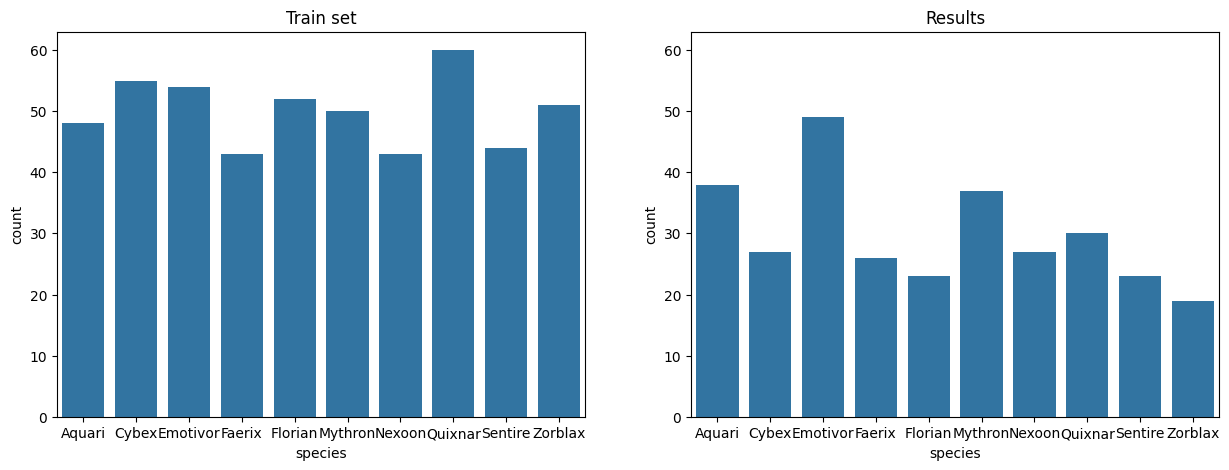

In [27]:
# test df
test = pd.read_csv('test.csv')

# Make predictions on the test set
test_predictions = best_model.predict(test[['message', 'fingers', 'tail']])

test_predictions = le.inverse_transform(test_predictions)

results = pd.DataFrame({'species': test_predictions})

train_species_df = pd.DataFrame({'species': le.inverse_transform(df['species'])})

species_counts = train_species_df['species'].value_counts()
species_counts = species_counts.reset_index()
species_counts.columns = ['species', 'count']
species_counts = species_counts.sort_values(by='species')

results_counts = results['species'].value_counts()
results_counts = results_counts.reset_index()
results_counts.columns = ['species', 'count']
results_counts = results_counts.sort_values(by='species')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='species', y='count', data=species_counts, ax=ax[0])
ax[0].set_title('Train set')
sns.barplot(x='species', y='count', data=results_counts, ax=ax[1])
ax[1].set_title('Results')
ax[1].set_ylim(ax[0].get_ylim())
plt.show()

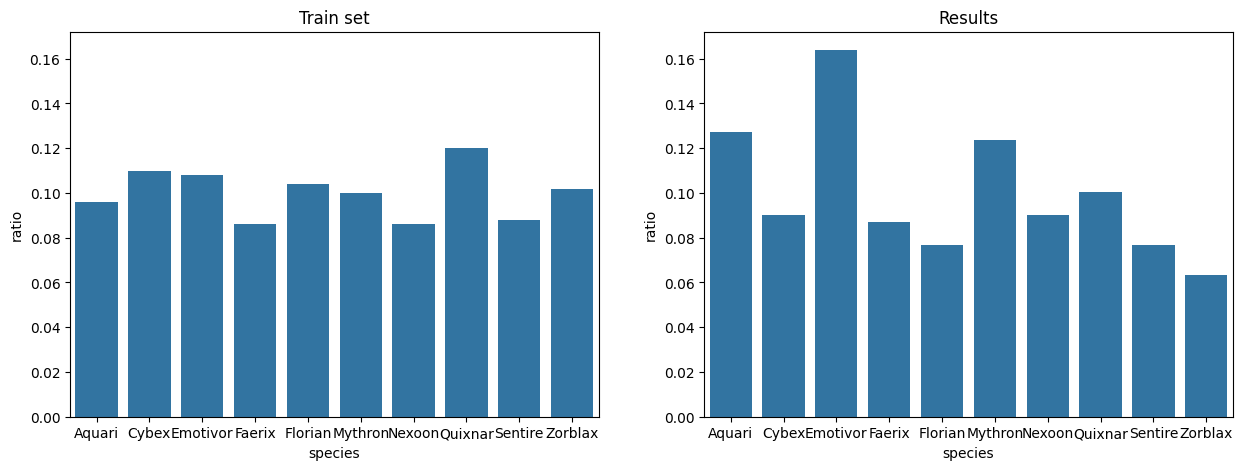

In [28]:
species_counts['ratio'] = species_counts['count'] / species_counts['count'].sum()
results_counts['ratio'] = results_counts['count'] / results_counts['count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='species', y='ratio', data=species_counts, ax=ax[0])
ax[0].set_title('Train set')
sns.barplot(x='species', y='ratio', data=results_counts, ax=ax[1])
ax[1].set_title('Results')
ax[0].set_ylim(ax[1].get_ylim())
plt.show()

In [29]:
summed_value = np.abs(species_counts['ratio'] - results_counts['ratio']).sum()

summed_value

0.1534314381270903

In [21]:
import xgboost as xgb

# new pipeline with xgboost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss'))
])

# Train the model
pipeline_xgb.fit(X_train, y_train)

# Predictions
predictions_xgb = pipeline_xgb.predict(X_test)

In [22]:
print(classification_report(y_test, predictions_xgb))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.83      0.91      0.87        11
           2       0.92      1.00      0.96        11
           3       0.50      0.67      0.57         9
           4       0.88      0.70      0.78        10
           5       0.75      0.60      0.67        10
           6       0.73      0.89      0.80         9
           7       0.77      0.83      0.80        12
           8       1.00      0.67      0.80         9
           9       0.78      0.70      0.74        10

    accuracy                           0.78       100
   macro avg       0.79      0.77      0.78       100
weighted avg       0.80      0.78      0.78       100



In [23]:
# grid search on hyperparameters
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 250],
    'classifier__max_depth': [3, 4, 5, None],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, verbose=1)
grid_search_xgb.fit(X_train, y_train)

best_model_xgb = grid_search_xgb.best_estimator_

best_predictions_xgb = best_model_xgb.predict(X_test)

print(classification_report(y_test, best_predictions_xgb))

# print the best hyperparameters
print("Best hyperparameters:", grid_search_xgb.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.90      0.82      0.86        11
           2       0.79      1.00      0.88        11
           3       0.50      0.67      0.57         9
           4       0.88      0.70      0.78        10
           5       0.75      0.60      0.67        10
           6       0.80      0.89      0.84         9
           7       0.77      0.83      0.80        12
           8       1.00      0.67      0.80         9
           9       0.78      0.70      0.74        10

    accuracy                           0.77       100
   macro avg       0.79      0.77      0.77       100
weighted avg       0.79      0.77      0.77       100

Best hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 250}


In [25]:
scores_xgb = cross_val_score(best_model_xgb, df[['message', 'fingers', 'tail']], df['species'], cv=3)

print("Mean cross-validation score:", np.mean(scores_xgb))

Mean cross-validation score: 0.7020056272996177


In [89]:
# bagging classifier
from sklearn.ensemble import BaggingClassifier

pipeline_bag = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(n_estimators=100))
])

# Train the model
pipeline_bag.fit(X_train, y_train)

# Predictions
predictions_bag = pipeline_bag.predict(X_test)

In [90]:
print(classification_report(y_test, predictions_bag))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.86      1.00      0.92        12
           2       0.89      1.00      0.94         8
           3       0.86      0.43      0.57        14
           4       0.70      0.78      0.74         9
           5       0.82      0.90      0.86        10
           6       1.00      0.71      0.83         7
           7       0.53      0.71      0.61        14
           8       1.00      0.89      0.94         9
           9       0.83      0.77      0.80        13

    accuracy                           0.79       100
   macro avg       0.83      0.82      0.81       100
weighted avg       0.81      0.79      0.79       100



In [91]:
# cross validation
scores_bag = cross_val_score(pipeline_bag, df[['message', 'fingers', 'tail']], df['species'], cv=5)

print("Mean cross-validation score:", np.mean(scores_bag))

Mean cross-validation score: 0.7140000000000001
